# Finding Exoplanets using Deep Learning

Data from the Kepler Space Telescope, via [Kaggle](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data?select=exoTest.csv). 

In this notebook I want to see what I can implement using FastAI, while I go through the FastAI [Practical Deep Learning course](https://course.fast.ai/).

The first step is to import some libraries we'll need. The data that we've been using is tabular CSV data, so we need `pandas` to read the data into a pandas Dataframe. We're also using the fastai library, so we'll import everything from `fastai.tabular.all` so that's available for us.

We want to do some visualisations of our data too, so we import `matplotlib` and `seaborn` for those.

In [1]:
from pathlib import Path
import pandas as pd
from fastai.tabular.all import *
import matplotlib.pyplot as plt
import seaborn as sns

import torch, random

To avoid problems when re-running the notebook, I am going to make eery source of randomness deterministic, by using a `SEED` value of 42.

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED, reproducible=True)        # FastAI helper (also sets torch.backends.cudnn.deterministic = True)

Read the CSVs into `train_df` and `test_df` using pandas. Here we're creating pandas DataFrame objects with all of the data in the CSV files.

In [3]:
path = Path('.')
train_df = pd.read_csv(path/'exoTrain.csv') # This will be our training and testing data, we'll split it out using fastai.
test_df  = pd.read_csv(path/'exoTest.csv')   # We'll save this for verification at the end, once our model has been trained.

Sanity check. Let's look at the shape of each DataFrame and the first 5 rows (the head) of the `train_df` object.

We find `train_df` has shape `(5087, 3198)`, meaning there are 5,087 rows with 3,198 rows. This is what we expect from the [description](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data/data?select=exoTrain.csv) of the file on Kaggle. Likewise, `test_df` has the same number of columns and 570 rows, also in line with its [description](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data/data?select=exoTest.csv).

In [4]:
train_df.shape, test_df.shape, train_df.head()

((5087, 3198),
 (570, 3198),
    LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
 0      2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
 1      2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
 2      2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
 3      2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
 4      2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   
 
     FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
 0   -96.27  -79.89  ...     -78.07    -102.15    -102.15      25.13   
 1   -85.33  -83.97  ...      -3.28     -32.21     -32.21     -24.89   
 2   486.39  436.56  ...     -71.69      13.31      13.31     -29.89   
 3   311.31  312.42  ...       5.71      -3.73      -3.73      30.05   
 4 -1022.71 -989.57  ...    -594.37    -401.66    -401.66    -357.24   
 
    FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
 0      48.57 

Let's see what this looks like by visualising some of this data. 

These are time-series data of light intensity recorded by NASA's Kepler space telescope (stored at the [Mikulski Archive](https://archive.stsci.edu/missions-and-data/k2)), so a line graph with the time axis should be a reasonable way to look at this. The cell below creates a function (`plot_star_flux`) to plot a star's light flux as contained in the dataset.

In [5]:
flux_cols = [col for col in train_df.columns if col.startswith("FLUX")]

# Set the Seaborn style for aesthetics
sns.set_style("white")

def plot_star_flux(df, row_index):
    """
    Plot the flux (light intensity) over time for a single star from the dataset.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing FLUX columns.
        row_index (int): The index of the row (star) to plot.
    """
    
    # Extract flux values for the selected star
    flux_values = df.loc[row_index, flux_cols].values

    # Set the style
    sns.set_style("white")
    
    # Plot
    plt.figure(figsize=(14, 4))
    plt.plot(range(len(flux_values)), flux_values, linewidth=2)

    # Add labels and title
    plt.title(f"Light Intensity (Flux) Over Time for Star #{row_index}")
    plt.xlabel("Time Step")
    plt.ylabel("Flux")
    
    # Clean up visual clutter
    plt.grid(False)
    sns.despine()
    plt.tight_layout()
    plt.show()
    


Let's take a look at a star with the label '2' from the `train_df`, a star which has a confirmed exoplanet.

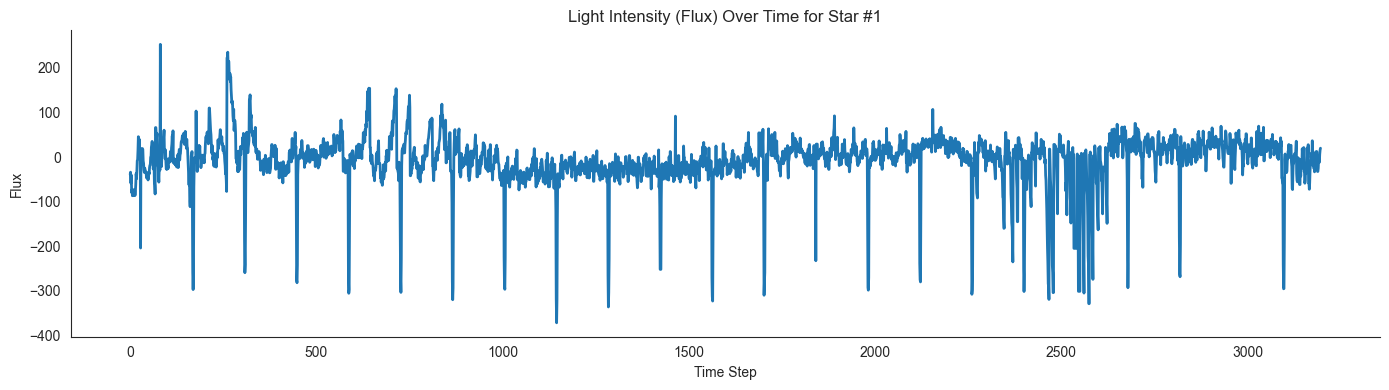

In [6]:
plot_star_flux(train_df, 1)

We can see the periodic light intensity dip - the tell-tale sign of an exoplanet! Let's check another star with a confirmed exoplanet, then look at the plots for a couple with no exoplanet for comparison.

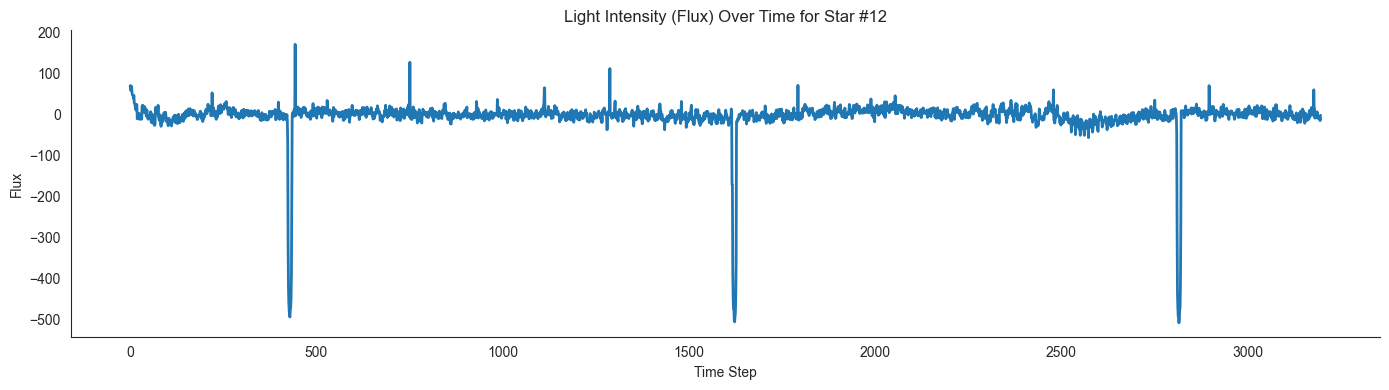

In [7]:
plot_star_flux(train_df, 12)

This one has a longer period than star number 1, but still has a clear pattern. Now let's look at a couple of plots for stars with no exoplanet, to see the difference.

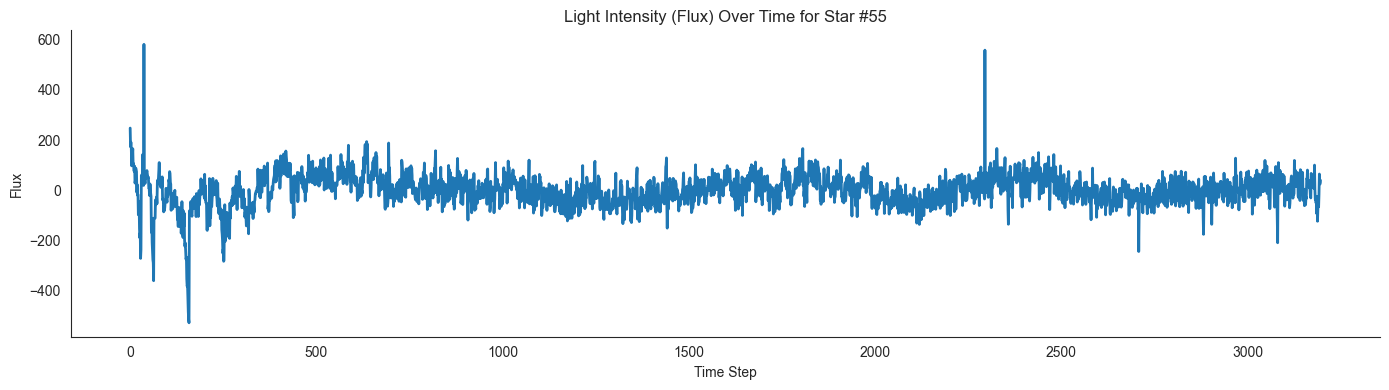

In [8]:
plot_star_flux(train_df, 55)

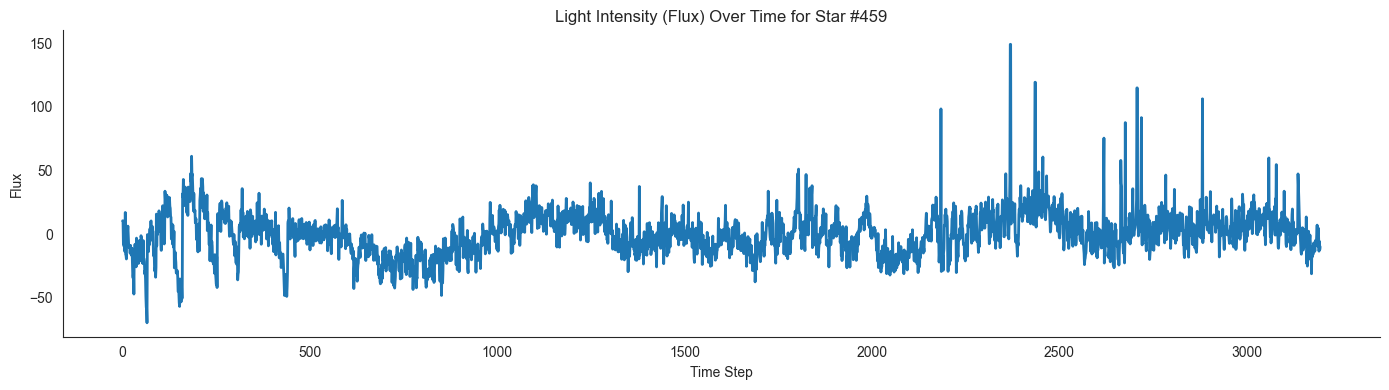

In [9]:
plot_star_flux(train_df, 459)

There's some strange outliers here, which we might have to deal with later, but for now let's leave them be.

Now let's do some light data preparation to give FastAI what it expects. We will shift the labels from 1 for non-exoplanet and 2 for exoplanet to 0 for non-exoplanet and 1 for exoplanet - this is easy to do, just subtract 1 from the label value for every row.

In [10]:
# FastAI wants class ids starting at 0 → map {1 (non‑exo) → 0, 2 (exo) → 1}
train_df['LABEL'] = train_df['LABEL'] - 1

Now for the main part. We use FastAI's [TabularDataLoaders](https://docs.fast.ai/tabular.data.html#tabulardataloaders) to easily create our [dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#datasets-dataloaders) from the 'train_df' DataFrame.

We explicitly set our parameters here to make clear what we are doing. Our dependent variable (the target, the label) is stored in the column `LABEL`, so we set `y_names = 'LABEL'`. The values of the other columns are continuous variables (the measurements of light intensity from the various stars), so we set `cont_names = flux_cols`, using the `flux_cols` object we defined previously.

We set `procs = [FillMissing, Normalize]` to add a couple of easy pre-processing steps to help FastAI out. `FillMissing` fills in missing values in the continuous columns (typically with the mean, but it can be another learned value). This shouldn't be necessary as this dataset has been pre-cleaned, but it doesn't cost much to do. `Normalize` standardizes the continuous features to zero mean and unit variance, which makes it easier for the neural network to do the calculations it needs to do while training.

Our problem is a categorisation problem - does the data show a star with the characteristic flux dips of an exoplanet, or not? So we set `y_block = CategoryBlock()`. `valid_pct` determines how much of the training set is used for testing after each epoch. This is the default 80 / 20 split, just made explicit here. `bs`determines how many rows are used in a single batch. 256 worked well here, but this can be adjusted as needed.

In [11]:
splits = RandomSplitter(valid_pct=0.2, seed=SEED)(range_of(train_df))

dls = TabularDataLoaders.from_df(
        df         = train_df,
        path       = path,
        y_names    = 'LABEL',
        cont_names = flux_cols,
        procs      = [FillMissing, Normalize],   # FillMissing is cheap insurance in case something is missing
        y_block    = CategoryBlock(),            # classification
        splits     = splits,                     # 80 / 20 split with determined split defined above
        bs         = 256                         # you may need to lower on small GPUs
)

The next step is to build a tabular learner using FastAI. This is our deep learning model.

In this case we are using a [tabular_learner](https://docs.fast.ai/tabular.learner.html), as our data is tabular (i.e. it's from a table). We provide it with our dataloaders object `dls`. `layers   = [2000,1000,1000,1000]`defines the layers of our model, in this case a fully connected feedforward network with four hidden layers, the first with 2,000 units and the following layers with 1,000 each.

In FastAI, tabular_learner uses Adam as the optimiser by default, so this is applied after each layer without us specifying it. The metrics we select are [accuracy](https://docs.fast.ai/metrics.html#accuracy), [RocAucBinary](https://docs.fast.ai/metrics.html#rocaucbinary) (a more nuanced metric than accuracy, useful especially when classes are imbalanced) and [F1Score](https://docs.fast.ai/metrics.html#f1score) - the harmonic mean of precision and recall.

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,time
0,0.755522,0.561177,0.995084,0.327075,0.992631,00:00
1,0.687550,0.449182,0.992134,0.746047,0.991154,00:00
2,0.606600,0.444981,0.990167,0.865217,0.990167,00:00
3,0.549838,0.431109,0.994100,0.865810,0.992140,00:00


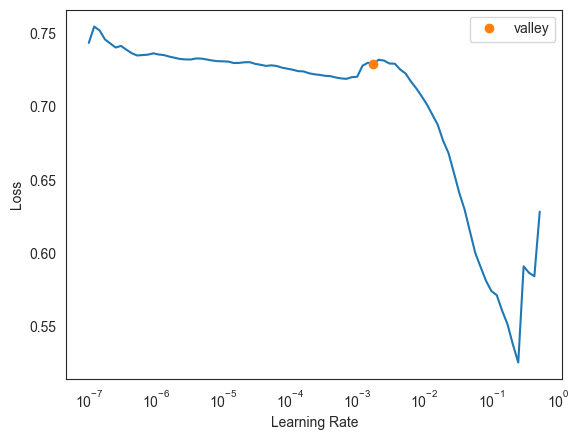

In [23]:
learn = 0 # reset the model so we can start again when needed

learn = tabular_learner(
        dls,
        layers   = [2000,1000,1000,1000],
        metrics  = [accuracy,
                    RocAucBinary(),
                    F1Score(average='weighted')]
)

# Now let's train the learner

learn.lr_find()          # pick a learning rate; note the suggested valley
learn.fit_one_cycle(4, 1e-3)

The results here look really promising, with accuracy of 99.4% and an AUC of 0.8658. That area under the curve score means that in ~87% of random positive/negative pairs, the model assigns a higher probability to the positive one. Sounds good. 

Let's save the model now so we have it safely stored in case our session disconnects or we need to restart the kernel.

In [24]:
learn.export('naive_baseline.pkl')

So the results are promising, but how is the model actually classifying the star data? Let's take a look at a [confusion matrix](https://www.sciencedirect.com/topics/engineering/confusion-matrix) to see how we're actually doing.

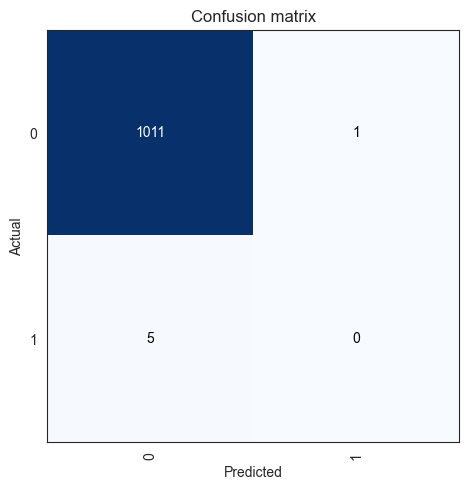

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

This is disappointing.

![Bad news](https://media4.giphy.com/media/v1.Y2lkPTc5MGI3NjExZjJmbjJldDEwMnY5bWM5ZnF6aTRkYTY3ZnowazNudmRncWM2MjRhZiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/MrvYF6AeVTzqg/giphy.gif)

The model perfectly classifies all examples where no exoplanet is detected, but it fails completely to predict the examples where there is an exoplanet. The model has simply learned that always predicting 0 (i.e. 'no exoplanet') gets it a very good score. This is because our dataset is extremely unbalanced. 

`train_df`contains 37 confirmed exoplanet stars vs 5,050 non-exoplanet stars - less than 1% of the training data belongs to the stars-with-exoplanet class. No wonder the model just always says "nope"!

There are ways to deal with this however. We will try a couple of different approaches. First, let's adjust the decision threshold, which is currently set at the default value of 0.5. Let's bring this down to 0.2 - this should make the model 'braver', or more willing to classify stars as having exoplanets.

In [26]:
probs, targs = learn.get_preds()

threshold = 0.2 # new threshold, as described above
new_preds = (probs[:,1] > threshold).int()

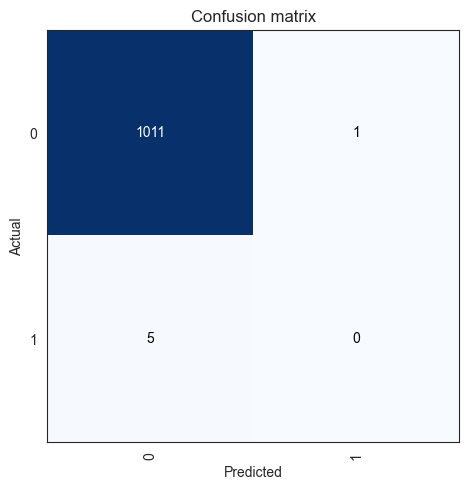

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Tragically, even dropping the threshold to 0.1 or 0.05 doesn't get us better results. We will have to get more creative!

## Dealing with the class imbalance

The main issue we have is that our training data is enormously imbalanced. We have 5,050 non-exoplanet stars compared with just 37 exoplanet stars. So how can we get our model working better? 

### Weighted Loss

One aproach is to adjust our loss function to put more weight on the positive cases (the rows in our data where the stars do have an exoplanet), compared to the much more plentiful negative cases (the rows with no exoplanet). This means that the effect of being incorrect on a positive case is more significant to the loss value than being incorrect on a negative case.

This should push our model to put more emphasis on the positive cases, and to 'be more careful' when making its assessments.

The below code implements this.

In [42]:
# 1. Class frequencies on the *training* split
train_labels = dls.train_ds.items['LABEL'].values
neg, pos = (train_labels == 0).sum(), (train_labels == 1).sum()

# 2. Weight for each class (higher weight → bigger penalty)
class_wts = torch.tensor([1.0, neg/pos]).float().to(dls.device)

loss_fn = CrossEntropyLossFlat(weight=class_wts)


In [45]:
learn = 0 # reset the model so we can re-run the cell as desired

learn = tabular_learner(
    dls,
    layers=[2000,1000,1000,1000],
    loss_func=loss_fn,
    metrics=[accuracy, RocAucBinary(), F1Score(average='weighted')]
)

# Now let's train the learner
learn.fit_one_cycle(8, 1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,time
0,0.633312,0.700332,0.015733,0.564427,0.021448,00:00
1,0.817034,0.928845,0.033432,0.583399,0.055491,00:00
2,0.887925,1.298006,0.038348,0.199012,0.064740,00:00
3,0.812812,0.626682,0.964602,0.441304,0.977154,00:00
4,0.722403,0.620467,0.986234,0.418379,0.988187,00:00
5,0.635937,0.604543,0.983284,0.439921,0.986697,00:00
6,0.568055,0.599488,0.984267,0.573715,0.987194,00:00
7,0.533911,0.587355,0.989184,0.799407,0.989673,00:00


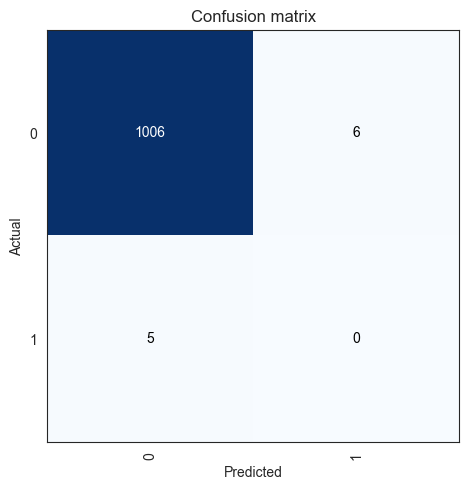

In [46]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

This is making a difference, but unfortunately not the kind we hoped for!

The model has not gotten any better at classifying the actual positive cases - the stars-with-exoplanets. It still predicts all of them as negative cases. The model has however become slightly *worse* at identifying the negative cases, stars-without-exoplanets, now giving 6 false positives as compared to just one before.

Let's save this model for reference, and see if any other techniques can help us improve performance.

In [47]:
learn.export('pos_weight_baseline.pkl')

### Minority-aware Sampling

This method uses oversampling (from the positive class) and undersampling (from the negative class) to give the model a perfectly balanced stream of examples. This should in theory make the model as good at identifying positive cases as it is at identifying negative cases. 

However, as we have only 37 positive cases in our training data (actually only 32, as 5 are in the test set we created with our split earlier), this introduces a very real risk of overfitting to the specific positive cases the model sees. We will also be reducing the number of negative cases the model sees, so we might expect reduced performance on that basis as well.

In [1]:
# This notebook is a WIP - I haven't implemented minority-aware sampling yet!

And some scikit learn code to get the ROC curve

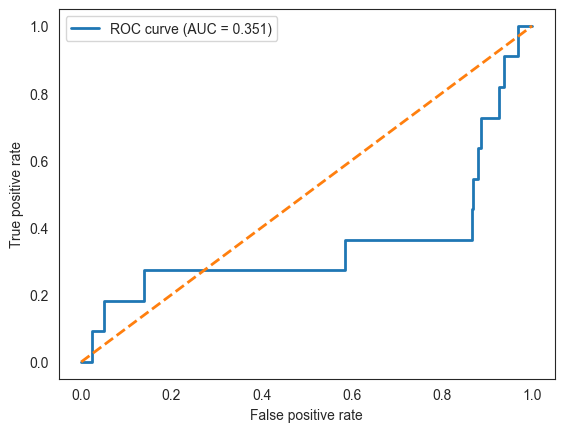

In [16]:
# after training
from sklearn.metrics import roc_curve, auc

probs, _ = learn.get_preds()          # preds is (n,2) → P(class0), P(class1)
fpr, tpr, _ = roc_curve(dls.valid.y, probs[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(); plt.plot(fpr, tpr, lw=2,
                       label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--',lw=2)
plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
plt.legend(); plt.show()

Let's predict using the held-out Kaggle test set (we're using this as our verification set here).

In [28]:
test_dl = dls.test_dl(test_df, with_labels=True)
preds, targs = learn.get_preds(dl=test_dl)

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Convert probabilities to predicted class labels
pred_labels = (preds[:,1] > 0.5).long()

# Accuracy
acc = accuracy_score(targs, pred_labels)

# ROC AUC (for binary)
roc = roc_auc_score(targs, preds[:,1])

# F1 Score (macro)
f1 = f1_score(targs, pred_labels, average='macro')

print(f"Accuracy:  {acc:.4f}")
print(f"ROC AUC:   {roc:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.0000
ROC AUC:   0.4060
F1 Score:  0.0000
